In [1]:
import torch as t
import numpy as np 
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import warnings

warnings.filterwarnings('ignore')

In [2]:
class NeuralNetworkForNumbers:

    # Инициализация
    def __init__(self, hiddenLevelNeuronsCount, imagePixelsCount, classCount):
        self.hiddenLevelNeuronsCount = hiddenLevelNeuronsCount # Количество нейронов скрытого слоя
        self.imagePixelsCount = imagePixelsCount # Количество пикселей изображения\размер входного слоя
        self.classCount = classCount # Количество классов
        self.weights = [1e-1 * t.randn(imagePixelsCount, hiddenLevelNeuronsCount), 1e-1 * t.randn(hiddenLevelNeuronsCount, classCount)] #Начальная матрица весов, веса задаем случайно
        self.displacementMatrix = [t.randn(hiddenLevelNeuronsCount)] # Начальная матрица смещений

    # Функция потерь
    def loss(self, yPred, yTrue):
        K = 10
        yRes = (yTrue[:,None] == t.arange(K))
        yRes = yRes.long()
        lossSample = (t.log(yPred) * yRes).sum(axis=1)
        res = t.mean(lossSample)
        return -res

    # Функция активации
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    # Многопеременная логистическая функция
    def softmax(self, x):
        return t.exp(x) / t.sum(t.exp(x), axis=1).reshape(-1,1)
    
    # Проход "вперёд" по нейроной сети, для вычисления выходов
    def forward(self, X):
        # Входной слой
        x1 = X
        # Скрытый слой
        x1 = t.matmul(x1, self.weights[0]) + self.displacementMatrix[0]
            
        # Функция активации второго слоя
        x2 = self.sigmoid(x1)
        # Выходной слой
        x2 = t.matmul(x2, self.weights[1])
        sigma = self.softmax(x2)
        return sigma
    
    # Функция вычисления градиентов функции ошибки по параметрам нейронной сети и формул коррекции весов
    def backprop(self, X, y, alpha=1e-4):
        K = 10
        N = X.size()[0]

        a1 = X
        x1 = t.matmul(a1, self.weights[0]) + self.displacementMatrix[0]
        a2 = self.sigmoid(x1)
        x2 = t.matmul(a2, self.weights[1])
        sigma = self.softmax(x2)
            
        # Подсчет градиента
        yRes = (y[:, None] == t.arange(K))
        yRes = yRes.long()
        delta2 = (sigma - yRes)
        gradW1 = np.matmul(a2.T, delta2)
            
        delta1 = np.matmul(delta2, self.weights[1].T) * (x1 > 0)
        gradW0 = np.matmul(a1.T, delta1)

        dWeight = [gradW0 / N + alpha * self.weights[0], gradW1 / N + alpha * self.weights[1]]
        dBack = [t.mean(delta1, axis=0)]
        return dWeight, dBack
    
    # Функция обучения
    def train(self, trainloader, statistic, epochs):

        gW0 = gW1 = gb0 = 1

        alpha = 1e-6 # Параметр регуляризации
        gamma = 0.99 # Параметр алгоритма оптимизации RMSprop
        eps = 1e-3 # Параметр алгоритма оптимизации RMSprop
        eta = 5e-1 # Параметр алгоритма оптимизации RMSprop

        for i in range(epochs):
            runningLoss = 0
            runningAcc = 0
            for images, labels in trainloader:

                images = images.view(-1, 784) 

                dWeight, dBack = self.backprop(images, labels, alpha)

                # После подсчета градиента, корректируем веса слоев и смещения
                gW0 = gamma * gW0 + (1 - gamma) * t.sum(dWeight[0] ** 2)
                etaW0 = eta / t.sqrt(gW0 + eps)
                self.weights[0] -= etaW0 * dWeight[0]
            
                gW1 = gamma * gW1 + (1 - gamma) * t.sum(dWeight[1] ** 2)
                etaW1 = eta / t.sqrt(gW1 + eps)
                self.weights[1] -= etaW1 * dWeight[1]

                gb0 = gamma * gb0 + (1 - gamma) * t.sum(dBack[0] ** 2)
                etab0 = eta / t.sqrt(gb0 + eps)
                self.displacementMatrix[0] -= etab0 * dBack[0]  
                
                gW0 = gW1 = gb0 = 1

                yPred = self.forward(images)
                runningLoss += self.loss(yPred, labels)
                res = t.argmax(yPred, axis = 1) == labels
                runningAcc += t.mean(res.float())

            runningLoss /= len(trainloader)
            runningAcc /= len(trainloader)
            statistic["historyLoss"].append(runningLoss)
            statistic["historyAcc"].append(runningAcc)
            statistic["hist"].append(i)
            print("Cross-entropy loss after", i + 1, "iterations is {:.8}".format(runningLoss))
            print("Training accuracy after", i + 1, "iterations is {:.4%}".format(runningAcc))

In [3]:
trainset = datasets.MNIST('data', train=True, download=True, transform = transforms.ToTensor())
trainloader = t.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.MNIST('data', train=False, download=True, transform = transforms.ToTensor())
testloader = t.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

statistic = {"hist": [], "historyAcc": [], "historyLoss": []}

model = NeuralNetworkForNumbers(hiddenLevelNeuronsCount=256, imagePixelsCount=28*28, classCount=10)
model.train(trainloader, statistic, epochs=10)

Cross-entropy loss after 1 iterations is 0.33596319
Training accuracy after 1 iterations is 90.5234%
Cross-entropy loss after 2 iterations is 0.16151486
Training accuracy after 2 iterations is 95.8655%
Cross-entropy loss after 3 iterations is 0.12703916
Training accuracy after 3 iterations is 96.8500%
Cross-entropy loss after 4 iterations is 0.104369
Training accuracy after 4 iterations is 97.5180%
Cross-entropy loss after 5 iterations is 0.087171368
Training accuracy after 5 iterations is 98.0527%
Cross-entropy loss after 6 iterations is 0.074476577
Training accuracy after 6 iterations is 98.2942%
Cross-entropy loss after 7 iterations is 0.06721478
Training accuracy after 7 iterations is 98.5341%
Cross-entropy loss after 8 iterations is 0.062544733
Training accuracy after 8 iterations is 98.6690%
Cross-entropy loss after 9 iterations is 0.057462912
Training accuracy after 9 iterations is 98.7707%
Cross-entropy loss after 10 iterations is 0.054147068
Training accuracy after 10 iteratio

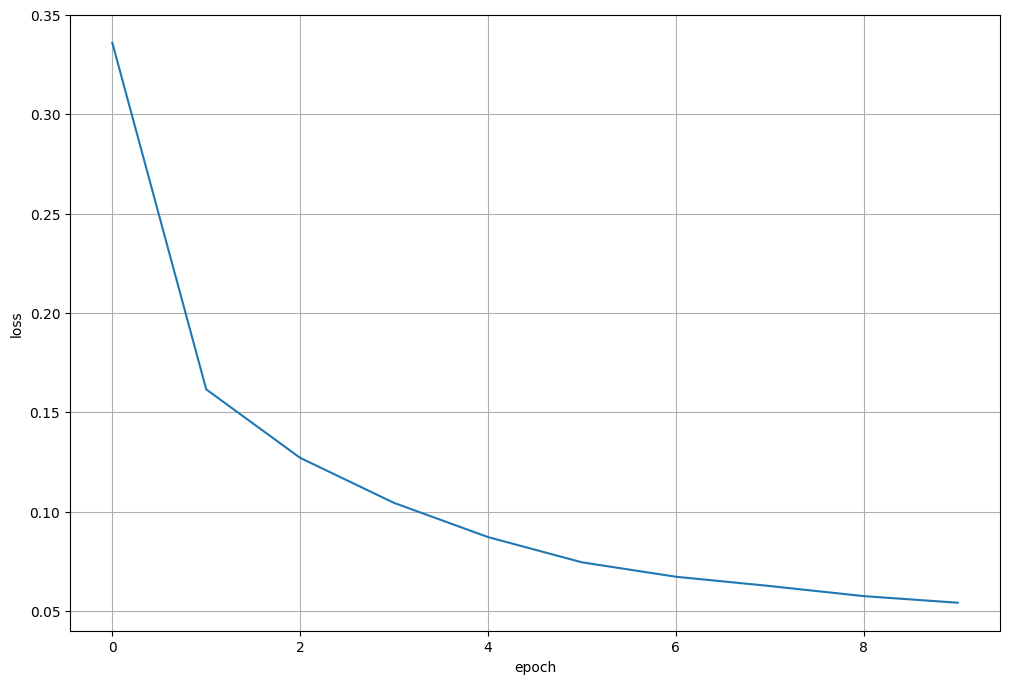

In [4]:
# Изобразим график потерь 
plt.figure(figsize=(12,8))
plt.plot(statistic["hist"], statistic["historyLoss"])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

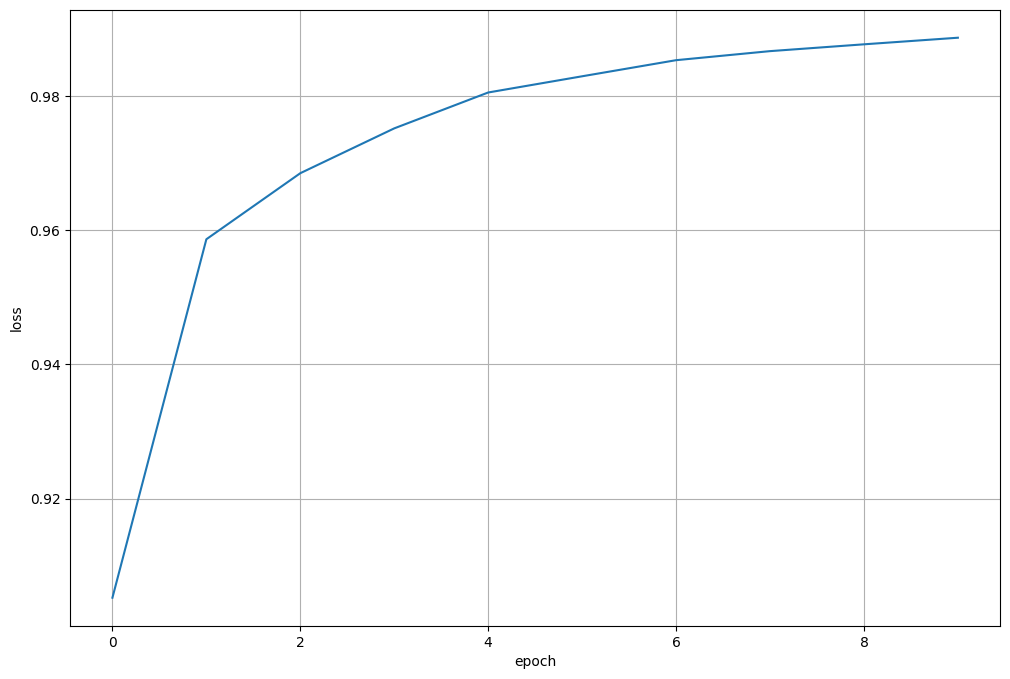

In [5]:
# Изобразим график потерь 
plt.figure(figsize=(12,8))
plt.plot(statistic["hist"], statistic["historyAcc"])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

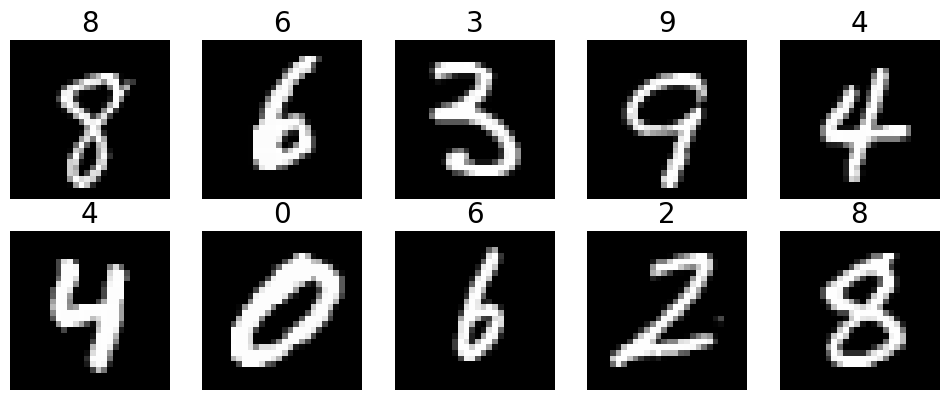

In [6]:
images, label = next(iter(trainloader))

plt.figure(figsize=(12, 12))
for i, image in enumerate(images[:10]):   
    pred = t.max(model.forward(image.view(-1, 784)), 1)[1]
    
    ax = plt.subplot(5, 5, i + 1)
    ax.axis('off')
    ax.imshow(image.numpy().transpose((1, 2, 0)).squeeze(), cmap='gray')
    ax.set_title(str(int(pred)), color= 'black', fontsize=20)